# PART I

In [1]:
!pip install torch 

In [2]:
pip install torchinfo


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np

# we will require this pkg to save the .pkl for the best weights
import pickle

# below are used for plotting visuals
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [47]:
 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
warnings.filterwarnings("ignore")

## STEP I

In [6]:
# read the csv file
df = pd.read_csv('datasets/dataset.csv')

In [7]:
df

,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1
...,...,...,...,...,...,...,...,...
761,9,89,62,0,0,22.5,e,0
762,10,101,76,48,180,d,0.171,0
763,2,122,70,27,b,36.8,0.34,0
764,c,121,72,23,112,26.2,0.245,0


In [8]:
# basic stats on the df
df.describe()

,f3,target
count,766.000000,766.000000
mean,69.118799,0.349869
std,19.376901,0.477240
min,0.000000,0.000000
25%,62.500000,0.000000
50%,72.000000,0.000000
75%,80.000000,1.000000
max,122.000000,1.000000


In [9]:
# we see that not all columns are numeric
df.dtypes

f1        object
f2        object
f3         int64
f4        object
f5        object
f6        object
f7        object
target     int64
dtype: object

In [10]:
# figure out the non numeric entries in our df
invalid_entries = {}

for col in df.columns:
    if df[col].dtype == 'object':
        invalid_values = df[col][pd.to_numeric(df[col], errors='coerce').isna()].unique()
        if len(invalid_values) > 0:
            invalid_entries[col] = invalid_values

print("Non-numeric entries detected:")
print(invalid_entries)

Non-numeric entries detected:
{'f1': array(['c'], dtype=object), 'f2': array(['f'], dtype=object), 'f4': array(['a'], dtype=object), 'f5': array(['b'], dtype=object), 'f6': array(['d'], dtype=object), 'f7': array(['e'], dtype=object)}


In [11]:
# replace them with NA
df = df.replace(['a', 'b', 'c', 'd', 'e', 'f'], pd.NA)


In [12]:
# make the cols numeric
df['f1'] = pd.to_numeric(df['f1'], errors='coerce')
df['f2'] = pd.to_numeric(df['f2'], errors='coerce')
df['f4'] = pd.to_numeric(df['f4'], errors='coerce')
df['f5'] = pd.to_numeric(df['f5'], errors='coerce')
df['f6'] = pd.to_numeric(df['f6'], errors='coerce')
df['f7'] = pd.to_numeric(df['f7'], errors='coerce')

In [13]:
df

,f1,f2,f3,f4,f5,f6,f7,target
0,6.0,148.0,72,35.0,0.0,33.6,0.627,1
1,1.0,85.0,66,29.0,0.0,26.6,0.351,0
2,8.0,183.0,64,0.0,0.0,23.3,0.672,1
3,1.0,89.0,66,23.0,94.0,28.1,0.167,0
4,0.0,137.0,40,35.0,168.0,43.1,2.288,1
...,...,...,...,...,...,...,...,...
761,9.0,89.0,62,0.0,0.0,22.5,NaN,0
762,10.0,101.0,76,48.0,180.0,NaN,0.171,0
763,2.0,122.0,70,27.0,NaN,36.8,0.340,0
764,NaN,121.0,72,23.0,112.0,26.2,0.245,0


In [14]:
# find out the NAN values in each col, We will impute them with mean using simple imputer in Step 2
print("Totol NAN Values in each feature\n", df.isna().sum())


Totol NAN Values in each feature
 f1        1
f2        1
f3        0
f4        1
f5        1
f6        1
f7        1
target    0
dtype: int64


In [15]:
# do we needd to preprocess our target for categorical cleaning?

print(f"Unique values in the target", df['target'].unique())

Unique values in the target [1 0]


In [16]:
# we doont need to preprocess traget col theres only 2 values (binary 0 and 1)

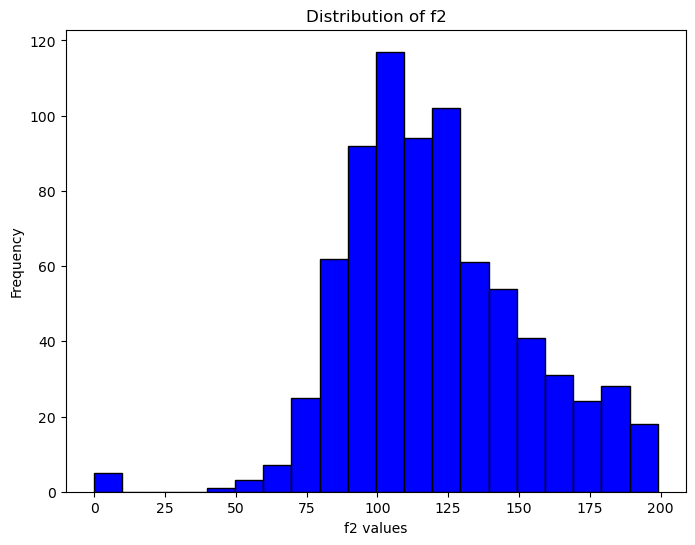

In [17]:
# F2 histogram
plt.figure(figsize=(8, 6))
plt.hist(df['f2'].dropna(), bins=20, color='blue', edgecolor='black')
plt.title('Distribution of f2')
plt.xlabel('f2 values')
plt.ylabel('Frequency')
plt.show()


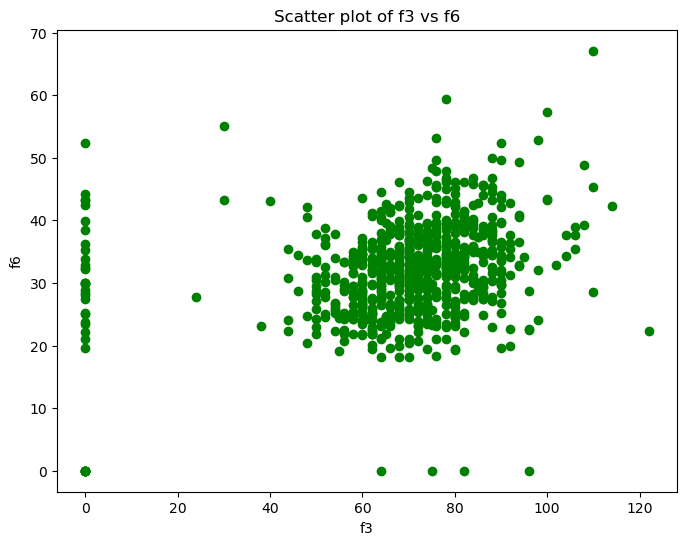

In [18]:
# f3 and f6 scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['f3'], df['f6'], color='green')
plt.title('Scatter plot of f3 vs f6')
plt.xlabel('f3')
plt.ylabel('f6')
plt.show()



<Figure size 800x600 with 0 Axes>

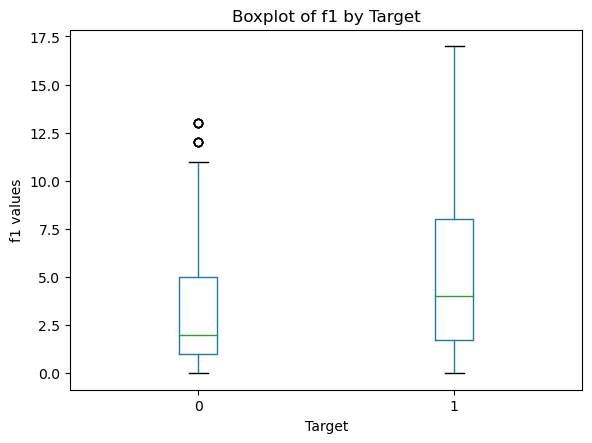

In [19]:
# f1 boxplot
plt.figure(figsize=(8, 6))
df.boxplot(column='f1', by='target', grid=False)
plt.title('Boxplot of f1 by Target')
plt.suptitle('')
plt.xlabel('Target')
plt.ylabel('f1 values')
plt.show()

---

# STEP 2

In [20]:
X = df.drop('target', axis=1)
y = df['target']


In [21]:
X 


,f1,f2,f3,f4,f5,f6,f7
0,6.0,148.0,72,35.0,0.0,33.6,0.627
1,1.0,85.0,66,29.0,0.0,26.6,0.351
2,8.0,183.0,64,0.0,0.0,23.3,0.672
3,1.0,89.0,66,23.0,94.0,28.1,0.167
4,0.0,137.0,40,35.0,168.0,43.1,2.288
...,...,...,...,...,...,...,...
761,9.0,89.0,62,0.0,0.0,22.5,NaN
762,10.0,101.0,76,48.0,180.0,NaN,0.171
763,2.0,122.0,70,27.0,NaN,36.8,0.340
764,NaN,121.0,72,23.0,112.0,26.2,0.245


In [22]:
y

0      1
1      0
2      1
3      0
4      1
      ..
761    0
762    0
763    0
764    0
765    1
Name: target, Length: 766, dtype: int64

In [23]:
numcols = X.select_dtypes(include=['int64', 'float64']).columns
print(numcols.tolist())

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']


In [24]:
scaler = StandardScaler()
X[numcols] = scaler.fit_transform(X[numcols])

In [25]:
X

,f1,f2,f3,f4,f5,f6,f7
0,0.637797,0.848503,0.148790,0.906423,-0.694642,0.202940,0.467428
1,-0.845227,-1.124745,-0.161060,0.530249,-0.694642,-0.683909,-0.365584
2,1.231007,1.944752,-0.264343,-1.287924,-0.694642,-1.101995,0.603245
3,-0.845227,-0.999460,-0.161060,0.154075,0.120630,-0.493870,-0.920925
4,-1.141831,0.503967,-1.503740,0.906423,0.762440,1.406521,5.480591
...,...,...,...,...,...,...,...
761,1.527612,-0.999460,-0.367626,-1.287924,-0.694642,-1.203349,NaN
762,1.824216,-0.623603,0.355356,1.721466,0.866517,NaN,-0.908853
763,-0.548622,0.034146,0.045507,0.404858,NaN,0.608357,-0.398784
764,NaN,0.002825,0.148790,0.154075,0.276746,-0.734586,-0.685509


In [26]:
imputer = SimpleImputer(strategy='mean')
X[numcols] = imputer.fit_transform(X[numcols])

In [27]:
X

,f1,f2,f3,f4,f5,f6,f7
0,6.377972e-01,0.848503,0.148790,9.064228e-01,-6.946421e-01,2.029403e-01,4.674281e-01
1,-8.452267e-01,-1.124745,-0.161060,5.302491e-01,-6.946421e-01,-6.839090e-01,-3.655839e-01
2,1.231007e+00,1.944752,-0.264343,-1.287924e+00,-6.946421e-01,-1.101995e+00,6.032453e-01
3,-8.452267e-01,-0.999460,-0.161060,1.540755e-01,1.206299e-01,-4.938699e-01,-9.209253e-01
4,-1.141831e+00,0.503967,-1.503740,9.064228e-01,7.624397e-01,1.406521e+00,5.480591e+00
...,...,...,...,...,...,...,...
761,1.527612e+00,-0.999460,-0.367626,-1.287924e+00,-6.946421e-01,-1.203349e+00,-3.018646e-17
762,1.824216e+00,-0.623603,0.355356,1.721466e+00,8.665170e-01,7.894919e-17,-9.088527e-01
763,-5.486219e-01,0.034146,0.045507,4.048579e-01,-5.166528e-17,6.083571e-01,-3.987837e-01
764,-5.108477e-17,0.002825,0.148790,1.540755e-01,2.767458e-01,-7.345862e-01,-6.855088e-01


In [28]:
# split the dataframe, Train 85% Test 15%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

#splitting training set into (82.35%) and validation (17.65%),, this makes 70-15-15 ratio of original set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.176, random_state=42, stratify=y_train)


In [29]:
print(f"Training shape: \t", y_train.shape)
print(f"Validation shape: \t", y_val.shape)
print(f"Teesting shape: \t", y_test.shape)

Training shape: 	 (536,)
Validation shape: 	 (115,)
Teesting shape: 	 (115,)


In [30]:
# conversion to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [31]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [32]:
print(f"Type of X_train_tensor: ",type(X_train_tensor))
print(f"Type of y_train_tensor: ",type(X_train_tensor))



Type of X_train_tensor:  <class 'torch.Tensor'>
Type of y_train_tensor:  <class 'torch.Tensor'>


In [33]:
print(f"Type of X_val_tensor: ",type(X_train_tensor))
print(f"Type of y_val_tensor: ",type(X_train_tensor))


Type of X_val_tensor:  <class 'torch.Tensor'>
Type of y_val_tensor:  <class 'torch.Tensor'>


In [34]:
print(f"Type of X_test_tensor: ",type(X_train_tensor))
print(f"Type of y_test_tensor: ",type(X_train_tensor))


Type of X_test_tensor:  <class 'torch.Tensor'>
Type of y_test_tensor:  <class 'torch.Tensor'>


In [35]:
# they are all tensors now.

---

# STEP 3

In [44]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = torch.sigmoid(self.fc3(x))          
        return x


In [45]:
input_features = X_train.shape[1]
hidden_size = 128

In [46]:
net = NeuralNetwork(input_features, hidden_size, 1).to(device)
summary(net, input_size=(1, input_features))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Linear: 1-1                            [1, 128]                  1,024
├─Linear: 1-2                            [1, 128]                  16,512
├─Linear: 1-3                            [1, 1]                    129
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07

---

# STEP 4